In [62]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [63]:
# Device Configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('✅ Using NVIDIA GPU (CUDA)')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('✅ Using Mac GPU (MPS)')
else:
    device = torch.device('cpu')
    print('⚠️ Using CPU')

✅ Using Mac GPU (MPS)


In [64]:
train_dir = "../data/seg_train/seg_train"
val_dir = "../data/seg_test/seg_test"
test_dir = "../data/seg_pred/seg_pred"

In [65]:
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),  # Flip images horizontally at random
    transforms.RandomRotation(10),  # Randomly rotate images by 10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Randomly changes image brightness, contrast, and saturation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [66]:
test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),  # Scales pixel values to [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Optional, adjust as needed
])

In [67]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=test_transform)

In [68]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

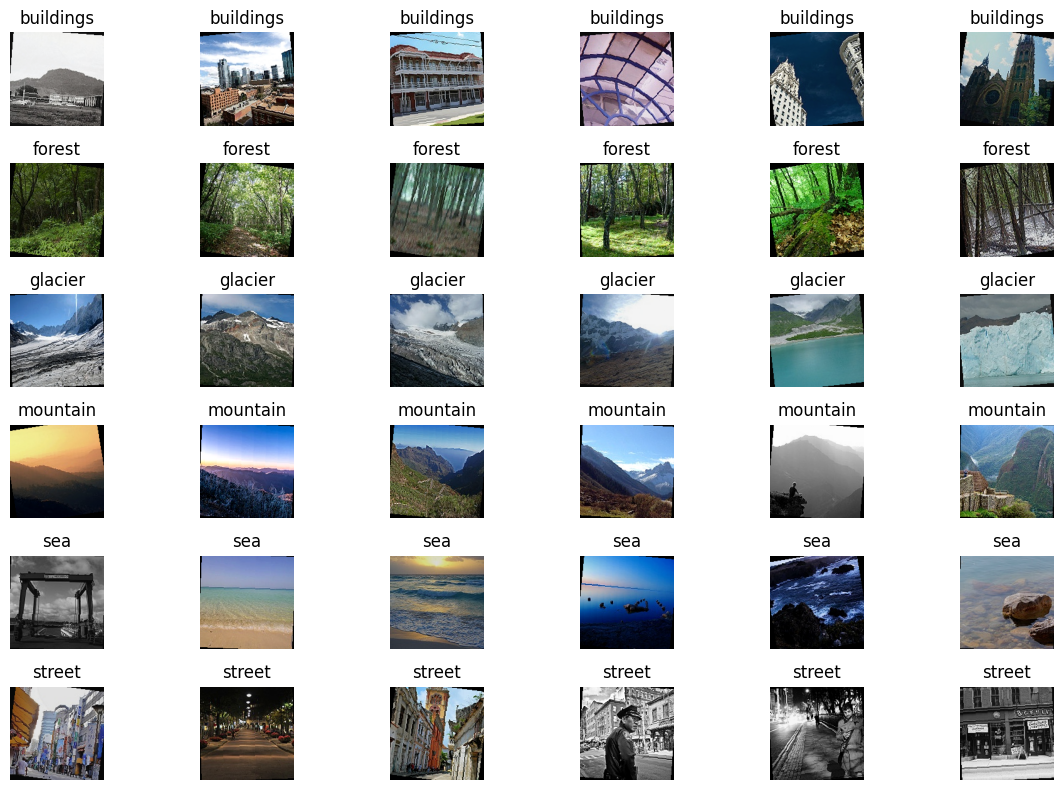

In [69]:
def show_images_from_each_class(dataset, num_classes=3, images_per_class=3):
    # Handle both Subset and ImageFolder
    # base_dataset = dataset.dataset if hasattr(dataset, 'dataset') else dataset
    class_indices = {v: k for k, v in dataset.class_to_idx.items()}
    
    shown = {i: 0 for i in range(num_classes)}
    
    plt.figure(figsize=(12, 8))
    i = 0
    for img, label in dataset:
        if shown[label] < images_per_class:
            i += 1
            plt.subplot(num_classes, images_per_class, i)
            img = img.permute(1, 2, 0).numpy()
            img = img * 0.5 + 0.5  # Undo normalization
            plt.imshow(img)
            plt.title(class_indices[label])
            plt.axis("off")
            shown[label] += 1
        if i >= num_classes * images_per_class:
            break
    plt.tight_layout()
    plt.show()

show_images_from_each_class(train_loader.dataset, num_classes=6, images_per_class=6)

In [70]:
class IntelCNN(nn.Module):
    def __init__(self, num_classes):
        super(IntelCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 37 * 37, 128)  # Assuming input size (3, 150, 150)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + Pool
        x = self.dropout(x)
        x = x.view(x.size(0), -1)             # Flatten
        x = F.relu(self.fc1(x))               # Dense
        x = self.fc2(x)                       # Output logits
        return x

In [71]:
num_classes = len(train_loader.dataset.classes)

model = IntelCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # CrossEntropy = softmax + categorical crossentropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [72]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        start = time.time()
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
              f"Time: {time.time()-start:.2f}s")

    return train_losses, val_losses, train_accs, val_accs

In [73]:
def plot_training(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses)+1)

    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.show()

Epoch 1/10 | Train Loss: 1.1030, Acc: 0.5797 | Val Loss: 0.8235, Acc: 0.6880 | Time: 37.96s
Epoch 2/10 | Train Loss: 0.7468, Acc: 0.7208 | Val Loss: 0.7514, Acc: 0.7523 | Time: 34.61s
Epoch 3/10 | Train Loss: 0.6282, Acc: 0.7705 | Val Loss: 0.6941, Acc: 0.7780 | Time: 34.56s
Epoch 4/10 | Train Loss: 0.5696, Acc: 0.7934 | Val Loss: 0.6788, Acc: 0.7943 | Time: 34.19s
Epoch 5/10 | Train Loss: 0.5245, Acc: 0.8060 | Val Loss: 0.7251, Acc: 0.7783 | Time: 34.27s
Epoch 6/10 | Train Loss: 0.4948, Acc: 0.8177 | Val Loss: 0.6423, Acc: 0.8143 | Time: 34.28s
Epoch 7/10 | Train Loss: 0.4638, Acc: 0.8322 | Val Loss: 0.6783, Acc: 0.7993 | Time: 34.47s
Epoch 8/10 | Train Loss: 0.4376, Acc: 0.8407 | Val Loss: 0.6497, Acc: 0.8217 | Time: 34.03s
Epoch 9/10 | Train Loss: 0.4120, Acc: 0.8505 | Val Loss: 0.6428, Acc: 0.8327 | Time: 37.80s
Epoch 10/10 | Train Loss: 0.3943, Acc: 0.8576 | Val Loss: 0.6138, Acc: 0.8340 | Time: 35.11s


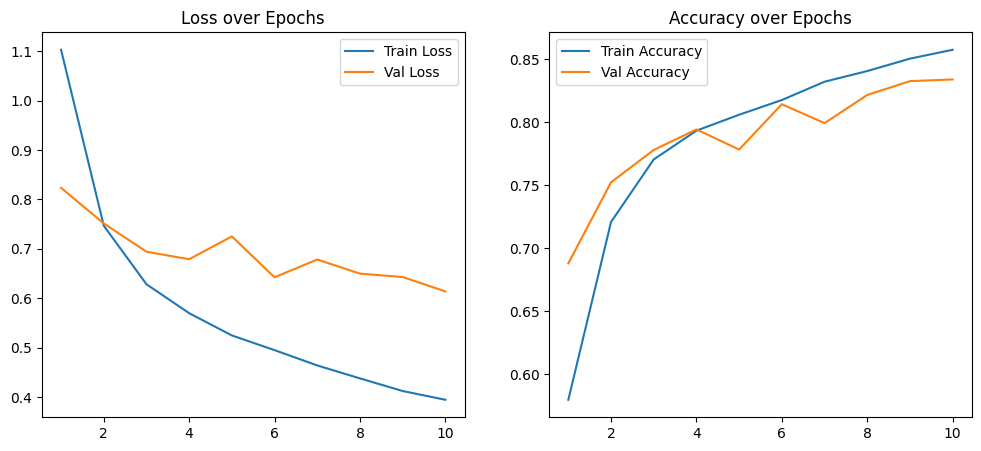

In [74]:
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=10
)

plot_training(train_losses, val_losses, train_accs, val_accs)

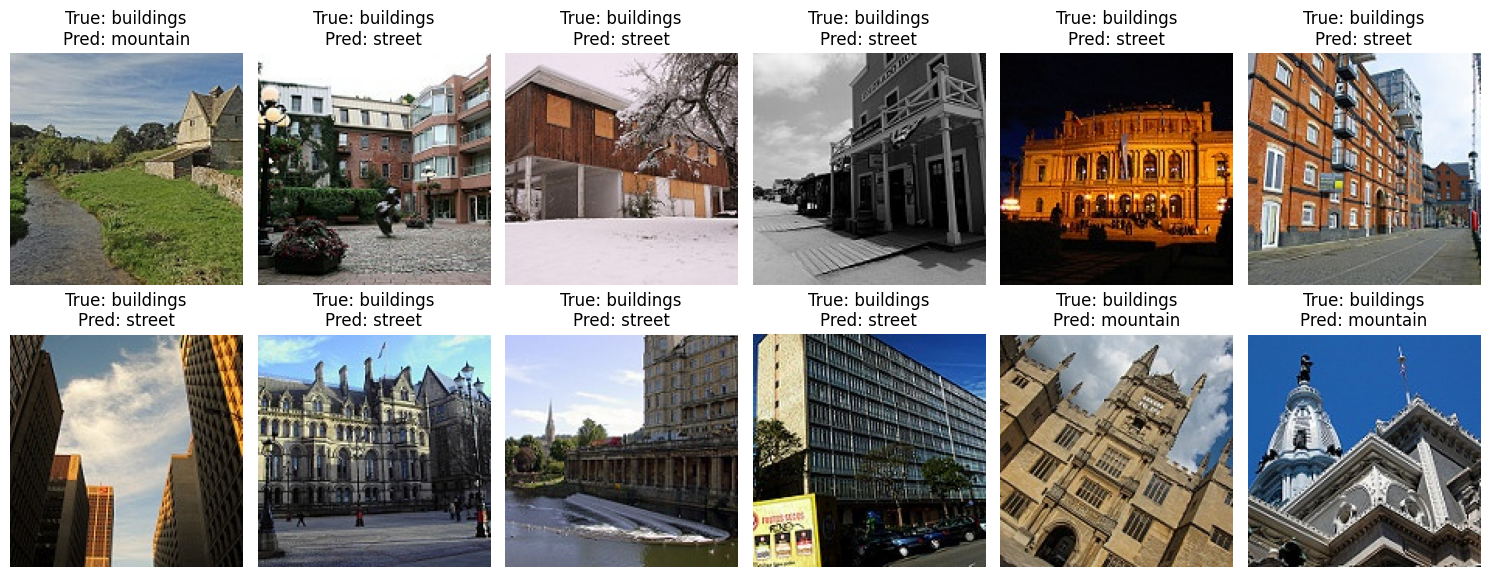

In [77]:
def show_misclassified(model, loader, class_names, max_images=12):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(), labels[i].item(), preds[i].item()))
                    if len(misclassified) >= max_images:
                        break
            if len(misclassified) >= max_images:
                break

    plt.figure(figsize=(15, 6))
    for i, (img, true_label, pred_label) in enumerate(misclassified):
        img = img.permute(1, 2, 0).numpy()
        img = img * 0.5 + 0.5  # Undo normalization

        plt.subplot(2, max_images // 2, i+1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_misclassified(model, val_loader, train_loader.dataset.classes, max_images=12)